## Install Libraries and Imports

To start, we install necessary libraries like PyTorch, PyG, and other helper libraries for graph processing and model evaluation.


In [14]:

import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv, GraphConv
from torch_geometric.data import DataLoader, Data
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("All libraries imported successfully.")


All libraries imported successfully.


## Load and Prepare Data

We load the dataset of logical expressions and correct graph responses. Each entry contains a query and its correct adjacency list as a response. The data is split into training, validation, and test sets.


Loading dataset...
Total correct results loaded: 8025
Sample Data Object:
tensor([0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2])
Node Label Distribution: Counter({0: 60212, 2: 42470, 1: 8025})
Edge Attribute Distribution: Counter({1.0: 99893, -1.0: 57727})

Visualizing CNF expression: x1 & (x1 | x4) & (x4 | ~x3) & (x4 | ~x4) & (x3 | x4 | ~x1) & (x2 | ~x1 | ~x2) & (x2 | x4 | ~x1 | ~x2)


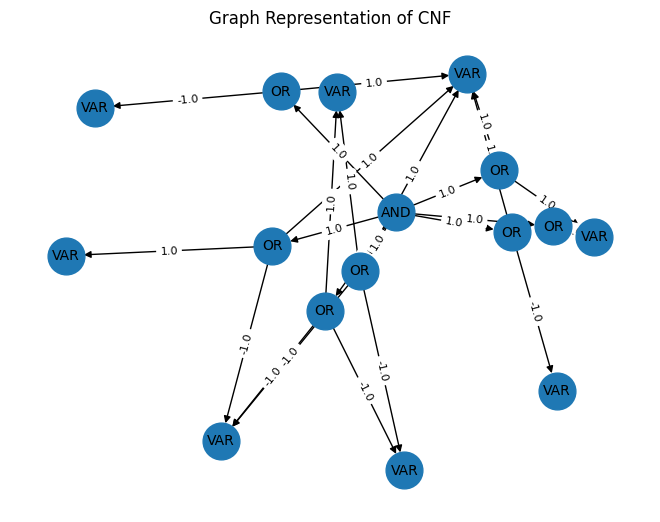

In [15]:
"""

Objective to train the model on a cnf - (~x1 | ~x2) & (x1 | ~x2 | ~x3 | ~x5) and get
from the model  graph_representation and node_labels

            "graph_representation": {
                "VAR_x1": [],
                "VAR_SymNotx2": [],
                "VAR_SymNotx1": [],
                "VAR_SymNotx5": [],
                "VAR_SymNotx3": [],
                "OR_clause_0": [
                    "VAR_SymNotx1",
                    "VAR_SymNotx2"
                ],
                "OR_clause_1": [
                    "VAR_SymNotx2",
                    "VAR_SymNotx3",
                    "VAR_SymNotx5",
                    "VAR_x1"
                ],
                "AND_final": [
                    "OR_clause_0",
                    "OR_clause_1"
                ]
            },
            
                        "node_labels": {
                "VAR_x1": "VAR",
                "VAR_SymNotx2": "VAR",
                "VAR_SymNotx1": "VAR",
                "VAR_SymNotx5": "VAR",
                "VAR_SymNotx3": "VAR",
                "OR_clause_0": "OR",
                "OR_clause_1": "OR",
                "AND_final": "AND"
            },
            
            
"""


# Validate the dataset
def validate_dataset(dataset):
    """
    Validates the integrity of the dataset.
    Checks node features, edge index, and node labels.
    """
    for idx, graph in enumerate(dataset):
        try:
            assert graph.x is not None and graph.x.ndim == 2, f"Graph {idx} has invalid node features (x)."
            assert graph.edge_index is not None and graph.edge_index.ndim == 2, f"Graph {idx} has invalid edge_index."
            assert graph.y is not None and graph.y.ndim == 1, f"Graph {idx} has invalid labels (y)."
            assert graph.edge_attr is not None, f"Graph {idx} is missing edge attributes (edge_attr)."
            assert graph.edge_index.shape[0] == 2, f"Graph {idx} edge_index should have 2 rows."
        except AssertionError as e:
            print(f"Validation Error in Graph {idx}: {e}")
            raise
    


from typing import Counter
from torch_geometric.data import Batch

from torch_geometric.data import Batch

def sanitize_dataset(dataset):
    valid_data = []
    for idx, data in enumerate(dataset):
        try:
            # Validate node features
            assert data.x is not None and data.x.ndim == 2, f"Invalid node features in graph {idx}"
            # Validate edge_index
            assert data.edge_index is not None and data.edge_index.ndim == 2, f"Invalid edge_index in graph {idx}"
            # Validate edge_attr
            if data.edge_attr is not None:
                assert data.edge_attr.size(0) == data.edge_index.size(1), f"Mismatched edge_attr and edge_index in graph {idx}"
            # Validate labels
            assert data.y is not None and data.y.size(0) == data.x.size(0), f"Mismatched node labels in graph {idx}"
            valid_data.append(data)
        except AssertionError as e:
            print(f"Skipping invalid graph {idx}: {e}")
    return valid_data







def custom_collate(batch):
    """
    Custom collation function for PyTorch Geometric that handles variable-sized graphs.
    Pads node features, edge indices, and edge attributes to align the batch.
    """
    max_nodes = max(data.x.size(0) for data in batch)
    max_edges = max(data.edge_index.size(1) for data in batch)

    for data in batch:
        # Pad node features
        pad_nodes = max_nodes - data.x.size(0)
        if pad_nodes > 0:
            data.x = torch.cat([data.x, torch.zeros(pad_nodes, data.x.size(1))], dim=0)
        
        # Pad edge attributes
        if data.edge_attr is not None:
            pad_edges = max_edges - data.edge_attr.size(0)
            if pad_edges > 0:
                data.edge_attr = torch.cat([data.edge_attr, torch.zeros(pad_edges)], dim=0)
        else:
            data.edge_attr = torch.zeros(max_edges)  # Default padding for missing edge_attr

        # Adjust edge_index
        edge_pad = max_edges - data.edge_index.size(1)
        if edge_pad > 0:
            pad_indices = torch.zeros((2, edge_pad), dtype=torch.long)
            data.edge_index = torch.cat([data.edge_index, pad_indices], dim=1)

    return Batch.from_data_list(batch)






# Convert graph representation and node labels into matrices
def convert_graph_to_matrices(graph_repr, node_labels):
    """
    Converts graph representation and node labels into adjacency matrix,
    edge index, feature matrix, edge attributes, and labels.
    """
    nodes = list(graph_repr.keys())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    adj_matrix = torch.zeros((len(nodes), len(nodes)), dtype=torch.float)
    edge_index = []
    edge_attr = []  # Edge attributes (polarity)

    for src, neighbors in graph_repr.items():
        src_idx = node_to_idx[src]
        for tgt in neighbors:
            tgt_idx = node_to_idx[tgt]
            adj_matrix[src_idx][tgt_idx] = 1
            edge_index.append([src_idx, tgt_idx])
            # Assign polarity based on `SymNot`
            if "SymNot" in tgt:
                edge_attr.append(-1)  # Negative polarity
            else:
                edge_attr.append(1)  # Positive polarity

    edge_index = torch.tensor(edge_index, dtype=torch.long).t() if edge_index else torch.empty((2, 0), dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.empty((0,), dtype=torch.float)

    # No further normalization of edge attributes
    # Remove this block to retain discrete values:
    # edge_attr = (edge_attr - edge_attr.mean()) / (edge_attr.std() + 1e-9)

    label_set = {"VAR": 0, "AND": 1, "OR": 2, "NOT": 3}
    feature_matrix = torch.zeros((len(nodes), len(label_set)), dtype=torch.float)
    for node, label in node_labels.items():
        feature_matrix[node_to_idx[node]][label_set[label]] = 1

    # Normalize node features
    feature_matrix = (feature_matrix - feature_matrix.mean(dim=0)) / (feature_matrix.std(dim=0) + 1e-9)

    y = torch.tensor([label_set[node_labels[node]] for node in nodes], dtype=torch.long)

    return adj_matrix, edge_index, feature_matrix, edge_attr, y




def prepare_edge_targets(edge_index, edge_attr):
    if edge_attr is None or len(edge_attr) == 0:
        print("Warning: Edge attributes are missing. Defaulting to class 0.")
        return torch.zeros(edge_index.size(1), dtype=torch.long)
    
    # Map edge attributes to classes: -1 -> 0, 0 -> 1, 1 -> 2
    edge_targets = ((edge_attr + 1) * (edge_attr != 0)).long()  # Ensure valid mapping
    return edge_targets


# Load and process the dataset
def load_correct_results(file_path):
    """
    Loads and processes the dataset from a JSON file.
    Associates CNF expressions with their graph representation and node labels.
    """
    try:
        with open(file_path, 'r') as f:
            dataset = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []

    data_list = []
    for idx, entry in enumerate(dataset.get("correct_results", [])):
        try:
            cnf_expression = entry["cnf_expression"]
            graph_repr = entry["graph_representation"]
            node_labels = entry["node_labels"]

            # Convert graph representation and labels to PyTorch tensors
            adj_matrix, edge_index, feature_matrix, edge_attr, y = convert_graph_to_matrices(graph_repr, node_labels)

            
            # Prepare edge targets
            edge_targets = prepare_edge_targets(edge_index, edge_attr)
            # Create Data object
            data = Data(
                x=feature_matrix,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=y,
                adj_matrix=adj_matrix,
                cnf_expression=cnf_expression,
                graph_repr=graph_repr,
                node_labels=node_labels,
                edge_targets=edge_targets
            )
            data_list.append(data)
        except Exception as e:
            print(f"Error processing entry {idx}: {e}")
            continue

    return data_list


# Split data and prepare DataLoaders
def split_and_prepare_dataloader(data_list, batch_size=1):
    """
    Splits the dataset into training and validation sets.
    Returns PyTorch Geometric DataLoaders for each split.
    """
    # Split the data into training (80%) and validation (20%)
    train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42)

    # Validate the datasets
    validate_dataset(train_data)
    validate_dataset(val_data)

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    return train_loader, val_loader


# Visualization
def visualize_graph(data):
    """
    Visualizes a graph using NetworkX with:
    - Node labels
    - Edge attributes
    """
    G = nx.DiGraph()
    edges = data.edge_index.t().tolist()
    G.add_edges_from(edges)

    node_labels_map = {i: label for i, label in enumerate(data.node_labels.values())}

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, labels=node_labels_map, with_labels=True, node_size=700, font_size=10)

    edge_labels = {
        (u, v): f"{data.edge_attr[i].item()}" for i, (u, v) in enumerate(edges)
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Graph Representation of CNF")
    plt.show()


def filter_invalid_graphs(data_list):
    valid_data = []
    for data in data_list:
        if data.x.size(0) > 0 and data.edge_index.size(1) > 0:
            valid_data.append(data)
    return valid_data

# Validate dataset diversity and balance
def check_dataset_diversity(data_list):
    node_label_distribution = Counter()
    edge_attribute_distribution = Counter()
    for data in data_list:
        node_label_distribution.update(data.y.tolist())
        if data.edge_attr is not None:
            edge_attribute_distribution.update(data.edge_attr.tolist())
    print("Node Label Distribution:", node_label_distribution)
    print("Edge Attribute Distribution:", edge_attribute_distribution)

# Call after loading dataset




# Main Execution
if __name__ == "__main__":
    input_filename = "cnf_evaluation_results_my_function.json"

    print("Loading dataset...")
    data = load_correct_results(input_filename)
    print(f"Total correct results loaded: {len(data)}")

    if data:
        print("Sample Data Object:")
        # print(data[0])
        # print all stuf in data[0]
        # print(data[0].keys)
        # print(data[0].x)
        # print(data[0].edge_index)
        # print(data[0].edge_attr)
        # print(data[0].y)
        # print(data[0].adj_matrix)
        # print(data[0].cnf_expression)
        # print(data[0].graph_repr)
        # print(data[0].node_labels)
        print(data[0].edge_targets)
        

        data = filter_invalid_graphs(data)
        check_dataset_diversity(data)
        # Split data and prepare DataLoaders
        sanitized_data = sanitize_dataset(data)
        
       


        train_loader, val_loader = split_and_prepare_dataloader(sanitized_data)

        # Visualize a sample graph
        print(f"\nVisualizing CNF expression: {data[2].cnf_expression}")
        visualize_graph(data[2])
    else:
        print("No data available for visualization.")  


## Define the GNN Model

We define a GNN architecture suitable for graph generation tasks, capable of learning adjacency structures from logical expressions. The architecture can be customized with various layers (e.g., GCN, GAT) based on model complexity and performance.


In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import TransformerConv, global_mean_pool

class CNFGraphTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_classes, node_classes, num_layers=6, num_heads=4, dropout_rate=0.1):
        """
        Transformer-based GNN model for predicting graph representations and node labels.

        Args:
            input_dim (int): Dimension of input node features.
            hidden_dim (int): Dimension of hidden layers.
            edge_classes (int): Number of edge classification classes.
            node_classes (int): Number of node classification classes.
            num_layers (int): Number of transformer layers.
            num_heads (int): Number of attention heads in transformer layers.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(CNFGraphTransformer, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Node embedding with normalization and dropout
        self.node_embedding = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Transformer layers for node embedding
        self.transformer_layers = nn.ModuleList([
            TransformerConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout_rate)
            for _ in range(num_layers)
        ])
        
        # Node classifier
        self.node_classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, node_classes)
        )
        
        # Edge predictor
        self.edge_predictor = nn.Sequential(
            nn.LayerNorm(2 * hidden_dim),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, edge_classes)
        )
        
    def forward(self, data):
        """
        Forward pass for batched graph data.

        Args:
            data (torch_geometric.data.Data): Input graph data.

        Returns:
            Tuple[Tensor, Tensor]: Edge predictions (logits) and node predictions (logits).
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Initial node embedding
        x = self.node_embedding(x)
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x = layer(x, edge_index)
        
        # Node classification logits
        node_logits = self.node_classifier(x)
        
        # Edge classification logits
        row, col = edge_index
        edge_features = torch.cat([x[row], x[col]], dim=-1)
        edge_logits = self.edge_predictor(edge_features)
        
        return edge_logits, node_logits


## Training the GNN Model

We train the model on our data, using cross-entropy loss. Hyperparameters such as learning rate, epochs, and batch size are configured to optimize performance.


In [4]:
# Hyperparameters based on best practices
# Hyperparameters
input_dim = 4
hidden_dim = 512  # Increased for more expressive power
edge_classes = 3
node_classes = 4
learning_rate = 1e-8  # Slower learning rate for stability
epochs = 50
patience = 10
dropout_rate = 0.1  # Increased for better regularization
num_layers = 16
num_heads = 8 # Increased for more expressive power
weight_decay = 1e-9  # Reduced to avoid over-penalizing weights
alpha = 0.8  # Balance between edge and node loss
accumulation_steps = 6  # Accumulate gradients for larger batch sizes


# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print hyperparameters for confirmation
print(f"Hyperparameters:")
print(f"Input Dim: {input_dim}, Hidden Dim: {hidden_dim}, Edge Classes: {edge_classes}, Node Classes: {node_classes}")
print(f"Learning Rate: {learning_rate}, Epochs: {epochs}, Patience: {patience}, Dropout Rate: {dropout_rate}")
print(f"Number of Layers: {num_layers}, Number of Attention Heads: {num_heads}")
print(f"Device: {device}")


Hyperparameters:
Input Dim: 4, Hidden Dim: 512, Edge Classes: 3, Node Classes: 4
Learning Rate: 1e-08, Epochs: 50, Patience: 10, Dropout Rate: 0.1
Number of Layers: 16, Number of Attention Heads: 8
Device: cpu


In [18]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Subset


# Helper function to validate targets
def validate_targets(targets, num_classes, target_name="Targets"):
    """
    Ensures targets are valid and within the expected range.
    """
    if (targets < 0).any() or (targets >= num_classes).any():
        raise ValueError(
            f"{target_name} contains invalid values. Expected in range [0, {num_classes - 1}], "
            f"but found {targets.tolist()}"
        )

# Helper function to validate and normalize inputs
def validate_inputs(data):
    """
    Validates and normalizes inputs for NaN/Inf values and adjusts node/edge features.
    """
    if torch.isnan(data.x).any() or torch.isinf(data.x).any():
        raise ValueError("Node features contain NaN or Inf values.")
    
    if data.edge_attr is not None:
        if torch.isnan(data.edge_attr).any() or torch.isinf(data.edge_attr).any():
            raise ValueError("Edge attributes contain NaN or Inf values.")

    # Normalize node features
    data.x = (data.x - data.x.mean(dim=0)) / (data.x.std(dim=0) + 1e-9)

    # Normalize edge attributes
    if data.edge_attr is not None:
        data.edge_attr = (data.edge_attr - data.edge_attr.mean()) / (data.edge_attr.std() + 1e-9)
    
    return data




# Combined loss function
def combined_loss(edge_logits, edge_targets, node_logits, node_targets, edge_loss_fn, node_loss_fn, alpha=0.5):
    """
    Combines edge prediction loss and node classification loss.
    """
    edge_loss = edge_loss_fn(edge_logits, edge_targets)
    node_loss = node_loss_fn(node_logits, node_targets)
    return alpha * edge_loss + (1 - alpha) * node_loss

# Preprocess edge targets
def create_sparse_edge_targets(edge_index, edge_attr=None, num_edge_classes=3):
    if edge_attr is not None:
        edge_attr = edge_attr.clamp(min=-1, max=1)  # Ensure attributes are in [-1, 0, 1]
        edge_targets = edge_attr + 1  # Shift range to [0, 1, 2]
        edge_targets = edge_targets.long()  # Convert to LongTensor
        assert edge_index.size(1) == edge_targets.size(0), \
            f"Mismatch: {edge_index.size(1)} edges but {edge_targets.size(0)} targets"
        return edge_index, edge_targets
    else:
        labels = torch.zeros(edge_index.size(1), dtype=torch.long)
        return edge_index, labels


# Training function focusing only on loss
def train_with_dynamic_sampling(
    model,
    train_loader,
    val_loader,
    optimizer,
    edge_loss_fn,
    node_loss_fn,
    scheduler=None,
    epochs=40,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    alpha=0.7,
    clip_grad_norm=1.0,
    update_interval=100,  # Number of graphs to process before optimization
    initial_sample_ratio=0.01,  # Start with 10% of the training data
    increment_ratio=0.01,  # Increase sampling by 10% each epoch
):
    """
    Trains the graph model using dynamic sampling for minibatches.

    Returns:
    - model: The trained model.
    - train_losses, val_losses: Lists of losses for training and validation.
    - loss_per_epoch: List of lists where each inner list contains [train_loss, val_loss] for each epoch.
    """
    train_losses, val_losses = [], []
    loss_per_epoch = []  # List to store [train_loss, val_loss] for each epoch
    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0

    full_train_dataset = train_loader.dataset  # Access the full training dataset
    num_samples = len(full_train_dataset)

    for epoch in range(1, epochs + 1):
        # Dynamically adjust the number of samples used for training
        sample_size = int(min(num_samples, num_samples * (initial_sample_ratio + (epoch - 1) * increment_ratio)))
        sampled_indices = torch.randperm(num_samples)[:sample_size]
        sampled_loader = DataLoader(
            Subset(full_train_dataset, sampled_indices),
            batch_size=train_loader.batch_size,
            shuffle=True,
            collate_fn=train_loader.collate_fn,
        )

        print(f"\nEpoch {epoch}/{epochs} started with {sample_size} samples.")
        model.train()
        train_loss = 0
        accumulated_loss = 0
        graph_counter = 0  # Track processed graphs for optimization interval

        for step, data in enumerate(sampled_loader, 1):
            data = validate_inputs(data.to(device))  # Validate and normalize inputs

            # Forward pass
            edge_logits, node_logits = model(data)

            # Prepare edge targets
            edge_index, edge_targets = create_sparse_edge_targets(
                data.edge_index, data.edge_attr, num_edge_classes=edge_logits.size(-1)
            )
            edge_targets = edge_targets.to(device)

            # Prepare node targets
            node_targets = data.y.to(device)

            # Compute combined loss
            loss = combined_loss(edge_logits, edge_targets, node_logits, node_targets, edge_loss_fn, node_loss_fn, alpha)
            loss.backward()

            # Accumulate loss and track graph count
            accumulated_loss += loss.item()
            graph_counter += data.num_graphs

            # Update parameters after processing `update_interval` graphs
            if graph_counter >= update_interval or step == len(sampled_loader):
                # Perform optimization
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

                train_loss += accumulated_loss  # Add to total train loss
                accumulated_loss = 0  # Reset accumulated loss
                graph_counter = 0  # Reset graph counter

        train_loss /= len(sampled_loader)
        train_losses.append(train_loss)

        # Validation phase
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                data = validate_inputs(data.to(device))  # Validate and normalize inputs

                edge_logits, node_logits = model(data)
                edge_index, edge_targets = create_sparse_edge_targets(
                    data.edge_index, data.edge_attr, num_edge_classes=edge_logits.size(-1)
                )
                edge_targets = edge_targets.to(device)
                node_targets = data.y.to(device)

                loss = combined_loss(edge_logits, edge_targets, node_logits, node_targets, edge_loss_fn, node_loss_fn, alpha)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch}: Train Loss = {train_loss:.4f}, "
            f"Val Loss = {val_loss:.4f}"
        )

        # Save losses for this epoch
        loss_per_epoch.append([train_loss, val_loss])

        # Early stopping and saving the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        # Adjust learning rate
        if scheduler:
            scheduler.step(val_loss)

    # Load the best model state
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, loss_per_epoch





## Block 3:

Define Evaluation Function for Model Testing (Run at End of Training)


In [19]:
# Initialize the model
model = CNFGraphTransformer(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    edge_classes=edge_classes,
    node_classes=node_classes,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout_rate=dropout_rate
).to(device)

# Define loss functions
edge_loss_fn = nn.CrossEntropyLoss()  # Edge classification loss
node_loss_fn = nn.CrossEntropyLoss()  # Node classification loss

# Optimizer and Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # SGD Optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


# Efficient data loaders using NeighborLoader

print("start training")
# Train the model
model, train_losses, val_losses , loss_per_epoch= train_with_dynamic_sampling(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    edge_loss_fn=edge_loss_fn,
    node_loss_fn=node_loss_fn,
    scheduler=scheduler,
    epochs=epochs,
    patience=patience,
    device=device,
    alpha=alpha
)

# save the model
torch.save(model.state_dict(), "testing_model.pth")


start training

Epoch 1/50 started with 64 samples.
Epoch 1: Train Loss = 1.2111, Val Loss = 1.1427

Epoch 2/50 started with 128 samples.
Epoch 2: Train Loss = 1.1247, Val Loss = 0.9335

Epoch 3/50 started with 192 samples.
Epoch 3: Train Loss = 0.8984, Val Loss = 0.7956

Epoch 4/50 started with 256 samples.
Epoch 4: Train Loss = 0.7585, Val Loss = 0.6669

Epoch 5/50 started with 321 samples.
Epoch 5: Train Loss = 0.6667, Val Loss = 0.5919

Epoch 6/50 started with 385 samples.
Epoch 6: Train Loss = 0.5667, Val Loss = 0.5353

Epoch 7/50 started with 449 samples.
Epoch 7: Train Loss = 0.5274, Val Loss = 0.4870

Epoch 8/50 started with 513 samples.
Epoch 8: Train Loss = 0.4753, Val Loss = 0.4560

Epoch 9/50 started with 577 samples.
Epoch 9: Train Loss = 0.4475, Val Loss = 0.4565

Epoch 10/50 started with 642 samples.
Epoch 10: Train Loss = 0.4432, Val Loss = 0.4504

Epoch 11/50 started with 706 samples.
Epoch 11: Train Loss = 0.4262, Val Loss = 0.4523

Epoch 12/50 started with 770 sample

Training Losses:
[1.211052130907774, 1.1247185915708542, 0.8983547830333313, 0.7584681969601661, 0.6667265284841306, 0.566698914688903, 0.5274090064660478, 0.4752704938891803, 0.44751236000238714, 0.4431857262909227, 0.4262049456071583, 0.4397756269419348, 0.43736972268536795, 0.45567595094176866, 0.4599946050721908, 0.4355491289348426, 0.4505125484561614, 0.4259625155301321, 0.46217891164399055, 0.4529406353599186, 0.4433545577022018, 0.4322194104576246, 0.45036651367740577, 0.4378994841273729, 0.4368636656401685, 0.43864738619777527, 0.4287355856543253, 0.4421644428072204, 0.43608253938033337, 0.4343218119468768, 0.4412230935528051]
Validation Losses:
[1.1426910129291619, 0.9334584636108898, 0.7956325952880479, 0.6669484514313695, 0.5919436270574172, 0.5352589285447962, 0.48702623721595123, 0.4560464649371269, 0.45645456362364817, 0.45042110805942265, 0.45226191456815534, 0.4498266459811142, 0.46055963932539445, 0.4495546220618988, 0.4612211620046342, 0.4496391073379932, 0.4505627700

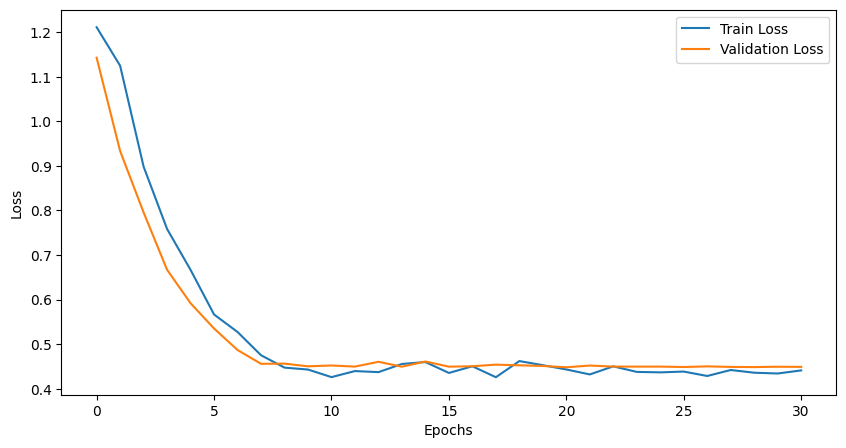

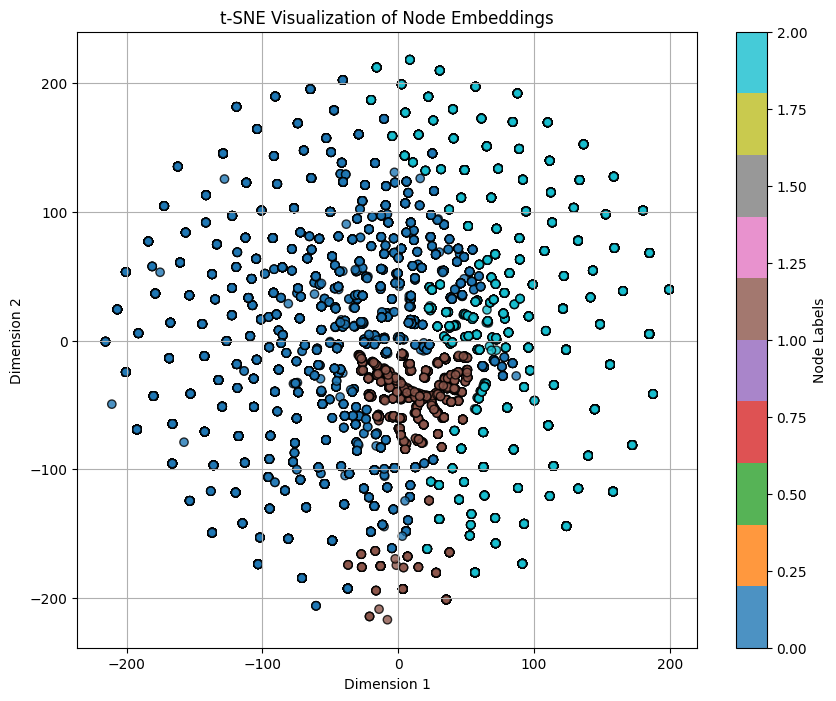

Silhouette Score for Clustering: 0.9994
Train Dataset Statistics:
Total Graphs: 6420
Total Nodes: 88282
Total Edges: 125195
Node Label Counts: {0: np.int64(48006), 1: np.int64(6420), 2: np.int64(33856)}
Validation Dataset Statistics:
Total Graphs: 1605
Total Nodes: 22425
Total Edges: 32425
Node Label Counts: {0: np.int64(12206), 1: np.int64(1605), 2: np.int64(8614)}
Edge Classification Report:
              precision    recall  f1-score   support

    Class -1       0.50      1.00      0.67     11952
     Class 0       0.00      0.00      0.00         0
     Class 1       0.00      0.00      0.00     20473

    accuracy                           0.37     32425
   macro avg       0.17      0.33      0.22     32425
weighted avg       0.19      0.37      0.25     32425

Confusion Matrix:
[[11952     0     0]
 [    0     0     0]
 [11859  8614     0]]
Edge Classification Accuracy: 0.3482


In [31]:
import torch
import torch.nn.functional as F
import json
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Plot training and validation losses
print("Training Losses:")
print(train_losses)
print("Validation Losses:")
print(val_losses)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Extract node embeddings from the trained model
def get_node_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            x, edge_index = data.x, data.edge_index

            # Compute node embeddings
            x = model.node_embedding(x)
            for layer in model.transformer_layers:
                x = layer(x, edge_index)
            
            embeddings.append(x.cpu().numpy())
            labels.append(data.y.cpu().numpy())

    return np.concatenate(embeddings), np.concatenate(labels)

node_embeddings, node_labels = get_node_embeddings(model, val_loader, device)

# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(node_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=node_labels, cmap='tab10', alpha=0.8, edgecolor='k'
)
plt.colorbar(scatter, label="Node Labels")
plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# Silhouette score
silhouette_avg = silhouette_score(node_embeddings, node_labels)
print(f"Silhouette Score for Clustering: {silhouette_avg:.4f}")

# Dataset statistics
def dataset_statistics(dataset):
    total_nodes = sum([data.num_nodes for data in dataset])
    total_edges = sum([data.num_edges for data in dataset])
    node_labels = [data.y.numpy() for data in dataset]
    node_label_counts = np.bincount(np.concatenate(node_labels))
    
    print(f"Total Graphs: {len(dataset)}")
    print(f"Total Nodes: {total_nodes}")
    print(f"Total Edges: {total_edges}")
    print(f"Node Label Counts: {dict(enumerate(node_label_counts))}")

print("Train Dataset Statistics:")
dataset_statistics(train_loader.dataset)
print("Validation Dataset Statistics:")
dataset_statistics(val_loader.dataset)

# Accuracy calculation for edges
def calculate_edge_accuracy(edge_logits, edge_targets):
    if edge_logits.size(0) != edge_targets.size(0):
        print(f"Mismatch: Logits {edge_logits.size(0)}, Targets {edge_targets.size(0)}")
        return 0.0
    
    preds = edge_logits.argmax(dim=-1)
    correct = (preds == edge_targets).sum().item()
    total = edge_targets.size(0)

    if total == 0:
        print("Warning: No targets provided for accuracy calculation.")
        return 0.0

    return correct / total

# Evaluate edge predictions
def evaluate_edge_predictions(model, val_loader, device):
    val_edge_accs = []
    all_edge_preds = []
    all_edge_targets = []

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            
            # Predictions
            edge_logits, _ = model(data)
            
            # Targets
            edge_targets = create_sparse_edge_targets(
                data.edge_index, data.edge_attr, num_edge_classes=edge_logits.size(-1)
            )[1].to(device)
            
            # Align shapes
            if edge_logits.size(0) != edge_targets.size(0):
                min_size = min(edge_logits.size(0), edge_targets.size(0))
                edge_logits = edge_logits[:min_size]
                edge_targets = edge_targets[:min_size]
            
            # Accuracy
            edge_acc = calculate_edge_accuracy(edge_logits, edge_targets)
            val_edge_accs.append(edge_acc)

            all_edge_preds.extend(edge_logits.argmax(dim=-1).cpu().numpy())
            all_edge_targets.extend(edge_targets.cpu().numpy())

    print("Edge Classification Report:")
    print(classification_report(all_edge_targets, all_edge_preds, zero_division=0, target_names=["Class -1", "Class 0", "Class 1"]))
    print("Confusion Matrix:")
    print(confusion_matrix(all_edge_targets, all_edge_preds))

    return np.mean(val_edge_accs)

edge_accuracy = evaluate_edge_predictions(model, val_loader, device)
print(f"Edge Classification Accuracy: {edge_accuracy:.4f}")








In [ ]:
import json
import torch
from torch_geometric.data import Data
from sympy import sympify, Or, And, Not

# Assuming CNFGraphTransformer is already defined and imported
# Load the trained model
model = CNFGraphTransformer(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    edge_classes=edge_classes,
    node_classes=node_classes,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout_rate=dropout_rate
)
model.load_state_dict(torch.load('testing_model.pth', map_location=torch.device('cpu')), strict=False)
model.eval()  # Set the model to evaluation mode

# Updated label set
label_set = {"VAR": 0, "AND": 1, "OR": 2, "NOT": 3}
inverse_label_set = {v: k for k, v in label_set.items()}


def parse_cnf_to_graph(cnf_expression, input_dim=4):
    """
    Converts a CNF expression into a graph representation suitable for the model.

    Args:
    - cnf_expression (str): The CNF expression (e.g., "(x1 | ~x2) & x3").
    - input_dim (int): The dimension of node features required by the model.

    Returns:
    - Data: PyTorch Geometric Data object with nodes, edges, and features.
    """
    expr = sympify(cnf_expression)  # Parse the CNF expression
    node_map = {}  # Map from node to its unique string identifier
    edge_index = []
    edge_attr = []
    feature_matrix = []  # This will hold the features for each node
    node_labels = []

    def add_node(node_name, node_type):
        """
        Adds a node to the graph if it doesn't already exist.
        """
        if node_name not in node_map:
            node_idx = len(node_map)
            node_map[node_name] = node_idx

            # Assign features and labels based on node type
            if node_type == "VAR":
                feature_vector = [1, 0, 0, 0]  # Feature vector for VAR
                label = label_set["VAR"]
            elif node_type == "OR":
                feature_vector = [0, 1, 0, 0]  # Feature vector for OR
                label = label_set["OR"]
            elif node_type == "AND":
                feature_vector = [0, 0, 1, 0]  # Feature vector for AND
                label = label_set["AND"]
            elif node_type == "NOT":
                feature_vector = [0, 0, 0, 1]  # Feature vector for NOT
                label = label_set["NOT"]
            else:
                raise ValueError(f"Unknown node type: {node_type}")

            # Ensure feature vector matches input_dim
            if len(feature_vector) < input_dim:
                feature_vector += [0] * (input_dim - len(feature_vector))  # Pad with zeros
            elif len(feature_vector) > input_dim:
                feature_vector = feature_vector[:input_dim]  # Truncate

            feature_matrix.append(feature_vector)  # Add to feature matrix
            node_labels.append(label)

    def process_clause(clause, clause_name):
        """
        Processes a logical clause and adds edges to the graph.
        """
        add_node(clause_name, "OR")
        for literal in clause.args:
            if isinstance(literal, Not):
                var_name = f"VAR_{literal.args[0]}"
                not_var_name = f"NOT_{var_name}"
                add_node(var_name, "VAR")
                add_node(not_var_name, "NOT")
                edge_index.append([node_map[not_var_name], node_map[var_name]])
                edge_index.append([node_map[clause_name], node_map[not_var_name]])
                edge_attr.extend([1, -1])
            else:
                var_name = f"VAR_{literal}"
                add_node(var_name, "VAR")
                edge_index.append([node_map[clause_name], node_map[var_name]])
                edge_attr.append(1)

    # Parse the expression into an AND clause structure
    if isinstance(expr, And):
        add_node("AND_final", "AND")
        for idx, clause in enumerate(expr.args):
            clause_name = f"OR_clause_{idx}"
            process_clause(clause, clause_name)
            edge_index.append([node_map["AND_final"], node_map[clause_name]])
            edge_attr.append(1)
    else:
        # Handle single OR clause or a simple variable
        process_clause(expr, "OR_clause_0")
        add_node("AND_final", "AND")
        edge_index.append([node_map["AND_final"], node_map["OR_clause_0"]])
        edge_attr.append(1)

    # Add all variables explicitly in the graph with empty connections
    for var in [f"VAR_{v}" for v in expr.free_symbols]:
        if var not in node_map:
            add_node(var, "VAR")

    # Convert to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t() if edge_index else torch.empty(2, 0, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.empty(0, dtype=torch.float)
    feature_matrix = torch.tensor(feature_matrix, dtype=torch.float) if feature_matrix else torch.empty(0, input_dim)
    node_labels = torch.tensor(node_labels, dtype=torch.long) if node_labels else torch.empty(0, dtype=torch.long)

    return Data(
        x=feature_matrix,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=node_labels,
        node_map={v: k for k, v in node_map.items()},
    )


def test_cnf_and_get_graph(cnf_expression):
    """
    Test the model with a CNF expression and generate a graph representation.
    """
    # Parse the CNF expression into a graph
    test_data = parse_cnf_to_graph(cnf_expression)

    # Ensure all required attributes are present
    assert test_data.x is not None, "Node features (x) are missing."
    assert test_data.edge_index is not None, "Edge index is missing."
    assert test_data.edge_index.size(0) == 2, "Edge index must have shape [2, num_edges]."

    # Perform inference
    with torch.no_grad():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        test_data.x = test_data.x.to(device)
        test_data.edge_index = test_data.edge_index.to(device)
        if test_data.edge_attr is not None:
            test_data.edge_attr = test_data.edge_attr.to(device)

        edge_logits, node_logits = model(test_data)

    # Convert edge_logits to predictions
    edge_predictions = edge_logits.argmax(dim=-1)  # Predicted edge classes
    graph_representation = {key: [] for key in test_data.node_map.values()}  # Initialize all nodes
    for (src, tgt), edge_pred in zip(test_data.edge_index.t().tolist(), edge_predictions.tolist()):
        src_node = test_data.node_map[src]
        tgt_node = test_data.node_map[tgt]
        graph_representation[src_node].append((tgt_node, edge_pred))  # Include predicted edge label

    # Convert node_logits to predictions
    node_predictions = node_logits.argmax(dim=-1)  # Predicted node classes
    node_labels = {
        test_data.node_map[idx]: inverse_label_set[node_predictions[idx].item()]
        for idx in range(len(node_predictions))
    }

    return {
        "CNF_expression": cnf_expression,
        "Graph Representation": graph_representation,
        "Node Labels": node_labels
    }



# we want to dymiacly red each cnf from the random_check_mode.json and save final result in the test_cn_new_model


# Load CNF expressions from JSON
input_file = "random_check_model.json"
output_file = "test_cnf_new_modelX.json"

with open(input_file, "r") as json_file:
    cnf_data = json.load(json_file)

results = {}


# Iterate through each CNF expression in the input file
for idx, cnf_expression in cnf_data.items():
    try:
        # Process and test each CNF expression      
        
        result = test_cnf_and_get_graph(cnf_expression)
        results[str(idx)] = result
        print(f"Processed CNF: {cnf_expression}, idx: {idx}")

    except Exception as e:
        # Handle errors for individual CNF expressions
        print(f"Error processing CNF {cnf_expression}: {e}")
        results[str(idx)] = {"error": str(e)}

# Save the results to the output JSON file
with open(output_file, "w") as json_file:
    json.dump(results, json_file, indent=4)

print(f"Results saved to {output_file}")


/var/folders/mz/rlnw5xwx0tl226nfr08wsfr40000gn/T/ipykernel_77680/2667102830.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('testing_mo

Processed CNF: ~x5, idx: 0
Processed CNF: x4 & ~x1 & ~x2 & (x4 | ~x1) & (x1 | ~x2 | ~x4) & (~x1 | ~x2 | ~x3) & (x1 | x2 | x3 | ~x1 | ~x2 | ~x4) & (x2 | x3 | x4 | ~x1 | ~x2 | ~x3 | ~x4), idx: 1
Processed CNF: x3 & x8 & ~x5 & (x2 | x4) & (x2 | x4 | x8) & (~x2 | ~x5) & (x4 | x7 | x9 | ~x2) & (x3 | x7 | ~x4 | ~x5) & (x2 | ~x10 | ~x5 | ~x9), idx: 2
Processed CNF: ~x6 & (x2 | x4) & (x1 | x4 | x5 | ~x2) & (x2 | x3 | ~x1 | ~x4) & (x2 | x4 | ~x5 | ~x6) & (x5 | x6 | ~x1 | ~x4) & (x2 | ~x1 | ~x3 | ~x5) & (x2 | x5 | x6 | ~x1 | ~x6) & (x4 | x5 | ~x3 | ~x4 | ~x5), idx: 3
Processed CNF: x3 & (x10 | ~x8) & (x1 | x7 | ~x3) & (x6 | ~x5 | ~x9) & (~x10 | ~x4 | ~x7) & (x2 | ~x6 | ~x7 | ~x8) & (x8 | ~x2 | ~x3 | ~x5) & (x1 | x8 | x9 | ~x6 | ~x9) & (~x2 | ~x3 | ~x4 | ~x6 | ~x9), idx: 4
Processed CNF: x1 & x2 & x3 & ~x1, idx: 5
Processed CNF: (x2 | x3) & (x1 | x3 | ~x3), idx: 6
Processed CNF: ~x1 & (x2 | x9) & (x8 | x9) & (x8 | ~x6) & (x7 | x8 | x9) & (x3 | x6 | ~x8) & (x5 | ~x1 | ~x5 | ~x7 | ~x8) & (x9 | ~x3 